## Mobile App A/A test [mini project]

###### The Task:
1. Run A/A-test
2. Compute FPR and compare it with significance value.
3. Make conclusion on A/A-test results.
4. Try to find the reason you've had such results.
5. Summarize.

###### Columns description
* experimentVariant – test group (0, 1)
* version – app's version
* purchase – conversion to purchase (0, 1)

**Importing libraries**

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
%matplotlib inline

**Importing dataset from a zipped csv-file in the working directory**

In [5]:
df = pd.read_csv('hw_aa.zip', compression='zip', sep=';')

df

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


**Checking missing values and columns datatypes**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127018 entries, 0 to 127017
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Unnamed: 0         127018 non-null  int64 
 1   uid                127018 non-null  object
 2   experimentVariant  127018 non-null  int64 
 3   version            127018 non-null  object
 4   purchase           127018 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.8+ MB


**Renaming columns**

In [7]:
df.rename(columns={'Unnamed: 0': 'seq', 'experimentVariant': 'group'}, inplace=True)

**Looking through the values in the dataframe**

In [8]:
# descriptive statistics
df.describe()

,seq,group,purchase
count,127018.000000,127018.000000,127018.000000
mean,63509.500000,0.503204,0.038687
std,36667.082583,0.499992,0.192850
min,1.000000,0.000000,0.000000
25%,31755.250000,0.000000,0.000000
50%,63509.500000,1.000000,0.000000
75%,95263.750000,1.000000,0.000000
max,127018.000000,1.000000,1.000000


In [9]:
# checking data splitting into groups
df.group.value_counts()

1    63916
0    63102
Name: group, dtype: int64

In [10]:
# finding out app's versions list
df.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

In [11]:
# checking for conversions
df.purchase.value_counts()

0    122104
1      4914
Name: purchase, dtype: int64

**Performing A/A test to find out how splitting algorithm worked for our data**

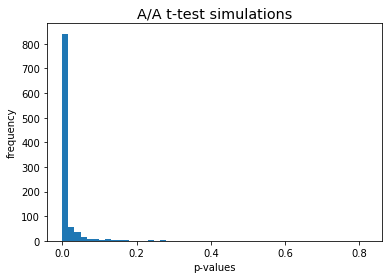

In [12]:
simulations = 1000  # the number of simulations
n_s = 1000  # number of values in a sample
alpha = 0.05  # significance value
res = []

# simulations
for i in tqdm(range(simulations)):
    s1 = df[df['group'] == 0].purchase.sample(n_s, replace=False).values
    s2 = df[df['group'] == 1].purchase.sample(n_s, replace=False).values
    res.append(stats.ttest_ind(s1, s2, equal_var=False)[1])

# visualizing
plt.hist(res, bins=50)
plt.style.use('bmh')
plt.xlabel('p-values')
plt.ylabel('frequency')
plt.title('A/A t-test simulations');

**Reporting results**

In [13]:
fpr = sum(np.array(res) < alpha) / simulations

if fpr < alpha:
    print('Splitting works well. A1=A2')
else:
    print('There are some problems with splitting system!')

There are some problems with splitting system!


**Looking for a problem that caused the result we have**

In [14]:
# grouping by group and version
gr_version = df.groupby(['group', 'version'], as_index=False) \
    .agg({'uid': 'count', 'purchase': 'sum'})

# calculating ctr
gr_version['ctr'] = round(gr_version.purchase / gr_version.uid, 3)

gr_version

,group,version,uid,purchase,ctr
0,0,v2.8.0,41283,41,0.001
1,0,v2.9.0,11921,890,0.075
2,0,v3.7.4.0,4204,252,0.060
3,0,v3.8.0.0,5694,328,0.058
4,1,v2.8.0,41552,1895,0.046
5,1,v2.9.0,12033,858,0.071
6,1,v3.7.4.0,4221,266,0.063
7,1,v3.8.0.0,6110,384,0.063


We can see that CTR for version v2.8.0 is considerably different for group 0 and group 1.   
**Let's check it statistically!**

In [15]:
# list of versions
versions = df.version.unique()
flg = 0

# running t-tests
for v in versions:
    p_val = stats.ttest_ind(df.query('group == 0 & version == @v').purchase,
                df.query('group == 1 & version == @v').purchase, equal_var=False)[1]
    if p_val < alpha:
        flg = 1
        print(f'There are problems with values in version {v}')
        
if flg == 0:
    print('We have checked all version. There are problems in none of them.')

There are problems with values in version v2.8.0


We have found the app's version that has problems with data.  
**We'll remove the verison from our dataframe**

In [16]:
df_clean = df[df['version'] != 'v2.8.0']

**Repeating A/A-test, but now without corrupted data**

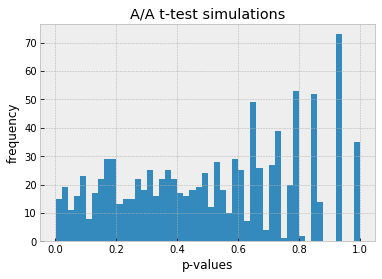

In [19]:
simulations = 1000  # the number of simulations
n_s = 1000  # number of values in a sample
alpha = 0.05  # significance value
res = []

# simulations
for i in tqdm(range(simulations)):
    s1 = df_clean[df_clean['group'] == 0].purchase.sample(n_s, replace=False).values
    s2 = df_clean[df_clean['group'] == 1].purchase.sample(n_s, replace=False).values
    res.append(stats.ttest_ind(s1, s2, equal_var=False)[1])

# visualizing
plt.hist(res, bins=50)
plt.style.use('bmh')
plt.xlabel('p-values')
plt.ylabel('frequency')
plt.title('A/A t-test simulations');

**Reporting results**

In [20]:
fpr = sum(np.array(res) < alpha) / simulations

if fpr < alpha:
    print('Splitting works well. A1=A2')
else:
    print('There are some problems with splitting system!')

Splitting works well. A1=A2


**Summary:**
* During the initial check of the splitting system using the A/A test, problems were identified in the results of the splitting system.
* While looking for the cause of malfunction we have identified the version of the application (v2.8.0) with the wrong data splitting.
* After removing the data related to the application version (v2.8.0) from the dataframe, the data "passed" the AA test. Now, we can safely conduct further experiments for the remaining versions of the applications (v2.9.0, v3.7.4.0, v3.8.0.0).